Results
--------------------
In this last section, we will look at the performance of our model by predicting on unseen data.

In [1]:
import tensorflow as tf
import numpy as np
from six.moves import cPickle as pickle
from scipy import ndimage
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    with open('tensorflow_data.pickle', 'rb') as f:
        dataset = pickle.load(f)
        train_dataset = dataset['train']['data'].reshape(-1, 32, 32, 1)
        test_dataset = dataset['test']['data'].reshape(-1, 32, 32, 1)
        validation_dataset = dataset['valid']['data'].reshape(-1, 32, 32, 1)
        extra_dataset = dataset['extra']['data'].reshape(-1, 32, 32, 1)
        train_labels = dataset['train']['label']
        test_labels = dataset['test']['label']
        validation_labels = dataset['valid']['label']
        extra_labels = dataset['extra']['label']

except Exception as e:
    print('Unable to process data from dataset.pickle', ':', e)
    raise

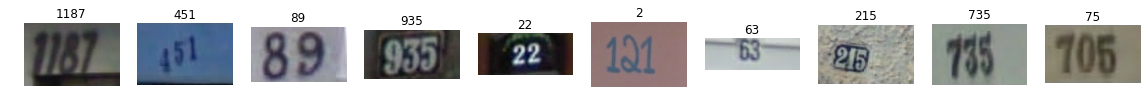

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, extra_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('extra', filename)
    im = Image.open(fullname)
    house_num = ''
    digits = extra_labels[j, :][extra_labels[j, :] < 10].astype(int)
    for k in digits:
        house_num += str(k)
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [4]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_test_dataset = tf.placeholder(tf.float32, shape=(10, 32, 32, 1))
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

  s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
  s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
  s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
  s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
  s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  
  # Model.
  def model(data, keep_prob, shape):
    conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
  
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_test_dataset, 1, [10, 32, 32, 1])

  predict = tf.pack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),tf.nn.softmax(logits3),\
                         tf.nn.softmax(logits4),tf.nn.softmax(logits5)])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver = tf.train.Saver()

In [5]:
with tf.Session(graph=graph) as session:
  saver.restore(session, "SVHN_MODEL.ckpt")
  test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : extra_dataset[im_samples,:,:,:],})

In [6]:
test_prediction

array([[ 3, 10, 10, 10, 10],
       [ 3, 10, 10, 10, 10],
       [10, 10, 10, 10, 10],
       [ 5, 10, 10, 10, 10],
       [ 2, 10, 10, 10, 10],
       [ 5,  3, 10, 10, 10],
       [ 3, 10, 10, 10, 10],
       [ 7, 10, 10, 10, 10],
       [ 5, 10, 10, 10, 10],
       [ 6, 10, 10, 10, 10]])

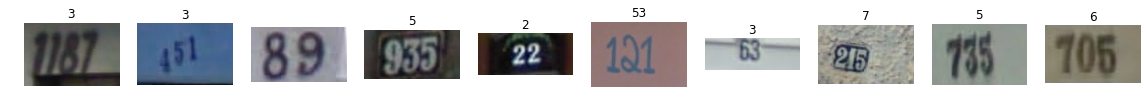

In [7]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    fullname = os.path.join('extra', filename)
    im = Image.open(fullname)
    house_num = ''
    digits = test_prediction[i, :][test_prediction[i, :] < 10].astype(int)
    for k in digits:
        house_num += str(k)
        
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)